## Libraries

In [ ]:
%pip install gymnasium
%pip install gymnasium[atari]
%pip install gymnasium[accept-rom-license]

In [2]:
import random
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange
%matplotlib inline

In [3]:
import torch
from torchinfo import summary
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset
from pytorch_lightning import LightningModule, Trainer

## Environment

In [4]:
import cv2
from gymnasium.core import ObservationWrapper
from gymnasium.spaces import Box
import matplotlib.pyplot as plt

class PreprocessAtari(ObservationWrapper):
    def __init__(self, env):
        ObservationWrapper.__init__(self, env)
        self.img_size = (64, 64)
        self.observation_space = Box(0.0, 1.0, (1, self.img_size[0], self.img_size[1]))

    def observation(self, img):
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img = img[57:-17, 6:-6]
        img = cv2.resize(img, self.img_size)
        img = img[np.newaxis,...]
        return img

In [5]:
from gymnasium.spaces.box import Box
from gymnasium.core import Wrapper

class FrameBuffer(Wrapper):
    def __init__(self, env, n_frames=4, dim_order='tensorflow'):
        super(FrameBuffer, self).__init__(env)
        self.dim_order = dim_order
        n_channels, height, width = env.observation_space.shape
        obs_shape = [n_channels * n_frames, height, width]
        self.observation_space = Box(0.0, 1.0, obs_shape)
        self.framebuffer = np.zeros(obs_shape, 'float32')
        
    def reset(self):
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(self.env.reset()[0])
        return self.framebuffer
    
    def step(self, action):
        new_img, reward, done, info, _ = self.env.step(action)
        self.update_buffer(new_img)
        return self.framebuffer, reward, done, info
    
    def update_buffer(self, img):
        offset = self.env.observation_space.shape[0]
        axis = 0
        cropped_framebuffer = self.framebuffer[:-offset]
        self.framebuffer = np.concatenate([img, cropped_framebuffer], axis = axis)

In [6]:
def make_env():
    env = gym.make("BreakoutDeterministic-v4")
    env = PreprocessAtari(env)
    env = FrameBuffer(env, n_frames=4, dim_order='pytorch')
    return env

env = make_env()
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


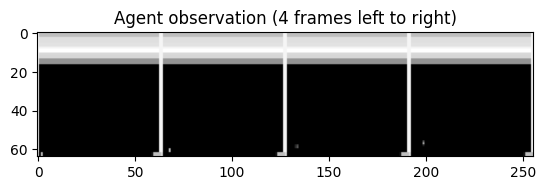

In [7]:
for _ in range(50):
    obs, _, _, _ = env.step(env.action_space.sample())


plt.title("Game image")
plt.title("Agent observation (4 frames left to right)")
plt.imshow(rearrange(obs, 'n h w -> h (n w)'), 'gray');

## Replay buffer

In [8]:
class ReplayBuffer(object):
    def __init__(self, size):
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        data = (obs_t, action, reward, obs_tp1, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, idxes):
        obses_t, actions, rewards, obses_tp1, dones = [], [], [], [], []
        for i in idxes:
            data = self._storage[i]
            obs_t, action, reward, obs_tp1, done = data
            obses_t.append(np.array(obs_t, copy=False))
            actions.append(np.array(action, copy=False))
            rewards.append(reward)
            obses_tp1.append(np.array(obs_tp1, copy=False))
            dones.append(done)
        return (
            np.array(obses_t),
            np.array(actions),
            np.array(rewards),
            np.array(obses_tp1),
            np.array(dones)
        )

    def sample(self, batch_size):
        idxes = [
            random.randint(0, len(self._storage) - 1)
            for _ in range(batch_size)
        ]
        return self._encode_sample(idxes)

In [9]:
class ReplayDataset(IterableDataset):
    
    def __init__(self, replay, batch_size):
        self.replay = replay
        self.batch_size = batch_size
        
    def __iter__(self):
        states, actions, rewards, next_states, dones = self.replay.sample(self.batch_size)
        for data in zip(states, actions, rewards, next_states, dones):
            yield data

## Agent

In [10]:
class Network(nn.Module):

    def __init__(self, obs_size, n_actions):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(obs_size[0], 16, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 256),
            nn.ReLU(),
            nn.Linear(256, n_actions),
        )

    def forward(self, x):
        return self.net(x.float())

In [17]:
class DQNAgent(LightningModule):
    
    def __init__(self, state_shape, n_actions, epsilon=0, gamma=0.99, buffer_size=10_000, 
                 populate_steps=1_000, batch_size=512, max_steps=10_000):
        super().__init__()
        self.save_hyperparameters()
        
        self.env = make_env()
        self.buffer = ReplayBuffer(buffer_size)
        self.state = self.env.reset()
        self.episode_reward = 0
        self.total_reward = 0
        
        self.model = Network(state_shape, self.hparams.n_actions)
        self.target_model = Network(state_shape, self.hparams.n_actions)
        
        self.populate()
        
    def populate(self):
        for _ in range(self.hparams.populate_steps):
            self.play_step()
        self.state = self.env.reset()
        
    def get_action(self, state, device):
        if random.random() < self.hparams.epsilon:
            return self.get_random_action()
        else:
            return self.get_best_action(state, device)
        
    def get_best_action(self, state, device):
        state = torch.tensor([state], device=device).float()
        qvalues = self.model(state)[0]
        best_action = torch.argmax(qvalues)
        return best_action.item()
   
    def get_random_action(self):
        return random.randint(0, self.hparams.n_actions-1)
    
    def update_epsilon(self):
        self.hparams.epsilon = max(self.hparams.epsilon * 0.99, 0.02)
    
    def copy_weights(self):
        self.model.load_state_dict(self.target_model.state_dict())
        
    def calculate_loss(self, batch):
        states, actions, rewards, next_states, dones = batch
        states = states.float()
        actions = actions.float()
        rewards = rewards.float()
        next_states = next_states.float()
        
        state_action_values = self.target_model(states).gather(1, actions.long().unsqueeze(-1)).squeeze(-1)

        with torch.no_grad():
            next_state_values = self.model(next_states).max(1)[0]
            next_state_values[dones] = 0.0
            next_state_values = next_state_values.detach()

        expected_state_action_values = next_state_values * self.hparams.gamma + rewards
        return nn.MSELoss()(state_action_values, expected_state_action_values)
    
    def play_step(self, device='cpu'):
        action = self.get_action(self.state, device)
        self.log('action', action)
        s_next, r, done, _ = self.env.step(action)
        self.buffer.add(self.state, action, r, s_next, done)
        self.state = s_next
        if done == True:
            self.state = self.env.reset()
        return r, done
    
    def training_step(self, batch, batch_no):
        device = self.get_device(batch)
        reward, done = self.play_step(device)
        self.episode_reward += reward
        
        self.log('step_reward', reward)
        
        self.log('total_reward', self.total_reward)
        
        if done == True:
            print('logging', self.episode_reward)
            self.total_reward = self.episode_reward
            self.episode_reward = 0
        
        loss = self.calculate_loss(batch)
        self.log('loss', loss)
        
        if self.global_step % 500 == 0:
            self.copy_weights()
            self.update_epsilon()
        
        self.log('epsilon', self.hparams.epsilon, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = Adam(self.target_model.parameters(), lr=0.001)
        return optimizer

    def train_dataloader(self):
        dataset = ReplayDataset(self.buffer, self.hparams.batch_size)
        dataloader = DataLoader(dataset=dataset, batch_size=self.hparams.batch_size)
        return dataloader
    
    def get_device(self, batch):
        return batch[0].device.index if self.on_gpu else "cpu"

## Training

In [18]:
agent = DQNAgent(state_dim, n_actions, epsilon=0.5)

trainer = Trainer(
    accelerator="gpu",
    max_epochs=-1,
    enable_progress_bar=False
    
    # val_check_interval=50,
)

trainer.fit(agent)

/home/klima7/studies/guzw/notebooks/conda/lib/python3.10/site-packages/pytorch_lightning/core/module.py:410: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type    | Params
-----------------------------------------
0 | model        | Network | 827 K 
1 | target_mo

logging 1.0
logging 0.0
logging 0.0
logging 1.0
logging 0.0
logging 2.0
logging 1.0
logging 3.0
logging 0.0


/home/klima7/studies/guzw/notebooks/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
class DQNAgent:
    def __init__(self, state_shape, n_actions, epsilon=0, gamma=0.99):
        """A simple DQN agent"""
        self.state_shape = state_shape
        self.n_action = n_actions
        self.epsilon = epsilon
        self.gamma = gamma
        
        self.model = self._create_network(state_shape, n_actions)
        self.target_model = self._create_network(state_shape, n_actions)
    
    def get_action(self, state, greedy=False):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy. """
        if not greedy and random.random() < self.epsilon:
            return self.get_random_action()
        else:
            return self.get_best_action(state)
    
    def get_best_action(self, state):
        qvalues = self.model.predict_on_batch(np.array([state]))[0]
        best_action = np.argmax(qvalues)
        return best_action
    
    def get_random_action(self):
        return random.randint(0, self.n_action-1)
    
    def replay(self, exp_replay, batch_size):
        states, actions, rewards, next_states, dones = exp_replay.sample(batch_size)
        
        merged = self.target_model.predict_on_batch(np.vstack([states, next_states]))
        outputs_target = merged[:batch_size]
        next_outputs_target = merged[batch_size:]
        next_outputs_model = self.model.predict_on_batch(np.array(next_states))
        
        data = []
        labels = []
        for state, action, reward, done, output_target, next_output_target, next_output_model in \
            zip(states, actions, rewards, dones, outputs_target, next_outputs_target, next_outputs_model):
            if done:
                expected_reward = reward
            else:
                index = np.argmax(next_output_target)
                expected_reward = reward + self.gamma * next_output_model[index]
                
            label = np.array(output_target)
            label[action] = expected_reward
            
            data.append(state)
            labels.append(label)
        
        data = np.array(data)
        labels = np.array(labels)
        
        self.target_model.train_on_batch(data, labels)
        
    def update_weights(self):
        """copy trained Q Network params to target Q Network"""
        self.model.set_weights(self.target_model.get_weights()) 
        
    def save(self):
        self.target_model.save_weights('breakout')
        
    def load(self):
        self.model.load_weights('breakout')
        self.target_model.load_weights('breakout')
    
    def _create_network(self, state_shape, n_actions):
        network = Sequential([
                InputLayer(state_shape),
                Conv2D(16, 3, strides=2, activation='relu'),
                Conv2D(32, 3, strides=2, activation='relu'),
                Conv2D(64, 3, strides=2, activation='relu'),
                Flatten(),
                Dense(256, activation='relu'),
                Dense(n_actions)
            ])
        network.compile(optimizer=Adam(amsgrad=True, learning_rate=0.0001), loss='mse')
        return network

2023-04-12 20:57:24.119109: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
agent = DQNAgent(state_dim, n_actions, epsilon=0.5)

2023-04-12 20:57:25.551756: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-12 20:57:25.625729: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-12 20:57:25.625871: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-12 20:57:25.626302: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operation

Now let's try out our agent to see if it raises any errors.

In [8]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            action = agent.get_action(s, greedy)
            s, r, done, _ = env.step(action)
            reward += r
            if done:
                break
        rewards.append(reward)
    return np.mean(rewards)

In [25]:
evaluate(env, agent, n_games=1)

2023-04-12 12:55:51.914515: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-04-12 12:55:52.671570: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


0.0

In [10]:
def play_and_record(agent, env, exp_replay, n_steps=1):
    """
    Play the game for exactly n steps, record every (s,a,r,s', done) to replay buffer. 
    Whenever game ends, add record with done=True and reset the game.
    It is guaranteed that env has done=False when passed to this function.
    
    PLEASE DO NOT RESET ENV UNLESS IT IS "DONE"
    
    :returns: return sum of rewards over time
    """
    # initial state
    reward = 0
    s = env.framebuffer
    step = 0
    while True:
        action = agent.get_action(s)
        s_next, r, done, _ = env.step(action)
        exp_replay.add(s, action, r, s_next, done)
        s = s_next
        step += 1
        reward += r
        if done:
            env.reset()
            s = env.framebuffer
        if step >= n_steps:
            return reward
    

In [32]:
# testing your code. This may take a minute...
exp_replay = ReplayBuffer(20000)

play_and_record(agent, env, exp_replay, n_steps=10000)

# if you're using your own experience replay buffer, some of those tests may need correction. 
# just make sure you know what your code does
assert len(exp_replay) == 10000, "play_and_record should have added exactly 10000 steps, "\
                                 "but instead added %i"%len(exp_replay)
is_dones = list(zip(*exp_replay._storage))[-1]

assert 0 < np.mean(is_dones) < 0.1, "Please make sure you restart the game whenever it is 'done' and record the is_done correctly into the buffer."\
                                    "Got %f is_done rate over %i steps. [If you think it's your tough luck, just re-run the test]"%(np.mean(is_dones), len(exp_replay))
    
for _ in range(100):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(10)
    assert obs_batch.shape == next_obs_batch.shape == (10,) + state_dim
    assert act_batch.shape == (10,), "actions batch should have shape (10,) but is instead %s"%str(act_batch.shape)
    assert reward_batch.shape == (10,), "rewards batch should have shape (10,) but is instead %s"%str(reward_batch.shape)
    assert is_done_batch.shape == (10,), "is_done batch should have shape (10,) but is instead %s"%str(is_done_batch.shape)
    assert [int(i) in (0,1) for i in is_dones], "is_done should be strictly True or False"
    assert [0 <= a <= n_actions for a in act_batch], "actions should be within [0, n_actions]"
    
print("Well done!")

Well done!


In [11]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
mean_rw_history = []

In [13]:
env = make_env()
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

exp_replay = ReplayBuffer(10**5)
agent = DQNAgent(state_dim, n_actions, epsilon=0.5)
play_and_record(agent, env, exp_replay, 10000)

buffer size = 100000, epsilon = 0.02000


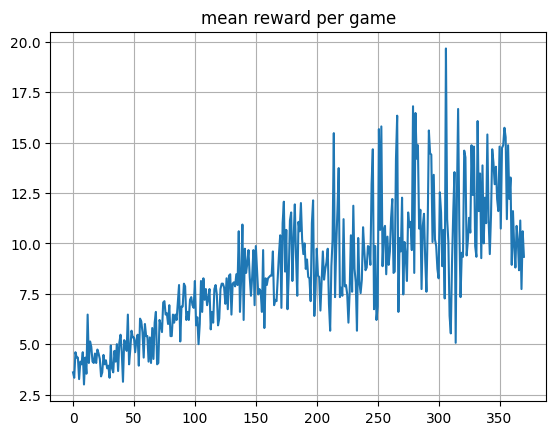

 16%|█▌        | 15639/100000 [1:21:42<7:20:45,  3.19it/s]  


In [24]:
for i in trange(10**5):
    
    # play
    play_and_record(agent, env, exp_replay, 10)
    
    # train
    agent.replay(exp_replay, 512)
    
    if i % 500 == 0:
        agent.update_weights()
        
    if i % 500 == 0:
        agent.epsilon = max(agent.epsilon * 0.99, 0.02)
    
    if i % 500 == 0:
        mean_rw_history.append(evaluate(make_env(), agent, n_games=15, greedy=False))
        agent.save()
        
    if i % 500 == 0:
        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" % (len(exp_replay), agent.epsilon))
        plt.title("mean reward per game")
        plt.plot(mean_rw_history)
        plt.grid()
        plt.show()